In [1]:
# ARIMA and variant test ( sarimax, sarima etc...)

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(14,4))
plt.rc("font", size=14)

In [280]:
uber = pd.read_csv('../uber_data.csv',index_col = 0,parse_dates = ['pickup_dt'])

In [281]:
uber_serie = uber[uber['borough'] == 'Manhattan']
uber_serie = uber_serie[['pickups']]
uber_serie = uber_serie[uber_serie.index < '2015-02-01']

In [282]:
uber_serie = uber_serie.asfreq('d')

In [283]:
uber_serie.plot()

Figure(id='11967', ...)

Evaluer si la série est stationnaire ou non 

In [284]:
from statsmodels.tsa.stattools import adfuller, kpss

In [285]:
adf, pa, *_  = adfuller(uber_serie.dropna())
print("p-value adf : ", pa)

p-value adf :  1.864380056313484e-05


In [286]:
uber_serie.plot()

Figure(id='12248', ...)

# lors de l'analyse sur un mois
La P-value est assez elevé, la serie a des chances de ne pas être stationnaire, il va falloir surement passer par une différenciation

# lors de l'analyse sur les 6 mois
La p-value est très faible donc la série est stationnaire
parce que ce que fait la P-value est d'imaginer un monde ou la série n'est pas stationnaire, à quelle point cela serait ridificule, probable ?
donc vu que la p-value est très faible ca rend notre null-hypothesis(null hypothesis => la serie n'est pas stationnaire) complètement ridicule et donc on peut en conclure que notre série est belle et bien stationnaire

In [287]:
from statsmodels.tsa.seasonal import STL, seasonal_decompose

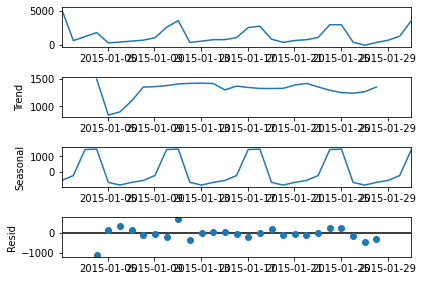

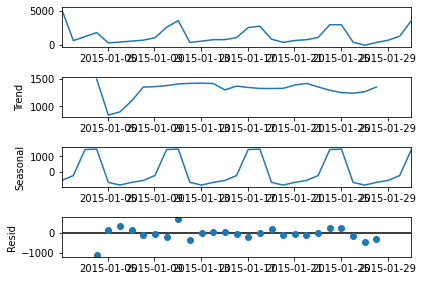

In [288]:
out = seasonal_decompose(uber_serie)
out.plot()

In [289]:
x =  out.observed - out.seasonal
x.plot()

Figure(id='12548', ...)

In [290]:
adf, pa, *_  = adfuller(x.dropna())
print("p-value adf : ", pa)

p-value adf :  0.021292946490581527


In [291]:
xd =  x.diff(1)
adf, pa, *_  = adfuller(xd.dropna())
print("p-value adf : ", pa)


p-value adf :  0.26562862485871097


La serie est devenu stationnaire apres une differenciation

# pour les 6 mois
quoi qu'il arrive la serie est stationnaire car p-value tres bas dans les 2 cas

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 15 must be < 15.

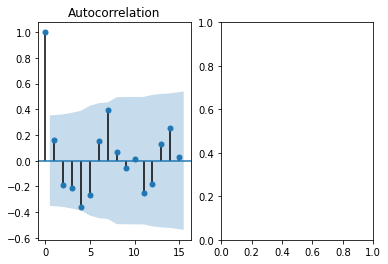

In [295]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2)
plot_acf(uber_serie.dropna(), ax=ax[0]) 
plot_pacf(uber_serie.dropna(), ax=ax[1]);

il semblerait un ordre 4 ou 5 peut etre

In [292]:
from statsmodels.tsa.arima.model import ARIMA 
mod = ARIMA(uber_serie, order=(5,1,0))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                pickups   No. Observations:                   31
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -252.089
Date:                Sat, 10 Oct 2020   AIC                            516.178
Time:                        17:00:13   BIC                            524.585
Sample:                    01-01-2015   HQIC                           518.867
                         - 01-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4714      0.170     -2.780      0.005      -0.804      -0.139
ar.L2         -0.5514      0.228     -2.417      0.016      -0.999      -0.104
ar.L3         -0.3772      0.247     -1.529      0.126      -0.861       0.106
ar.L4         -0.4361      0.386     -1.131      0.258      -1.192       0.320
ar.L5         -0.5201      0.133     -3.916      0.000      -0.780      -0.260
sigma2      1.135e+06   3.21e+05      3.537      0.000    5.06e+05    1.76e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                 2.48
Prob(Q):                              0.51   Prob(JB):                         0.29
Heteroskedasticity (H):               0.29   Skew:                            -0.56
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [293]:
res.aicc

519.829919183951

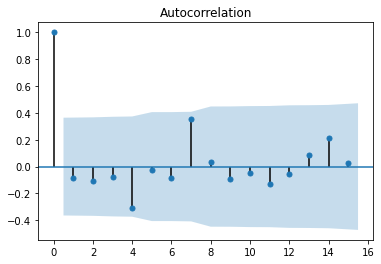

In [294]:
residus = res.resid[2:]
residus.plot(title="Résidus")
plot_acf(residus);

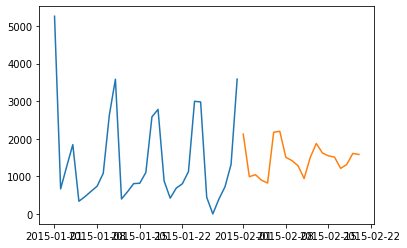

In [297]:
#x.plot()
#res.forecast(5).plot()
plt.plot(uber_serie)
plt.plot(res.forecast(20))

In [298]:
uber_sarimax = x.copy()

In [299]:
uber_sarimax

pickup_dt
2015-01-01 01:00:00    5791.090136
2015-01-02 01:00:00     887.090136
2015-01-03 01:00:00    -169.481293
2015-01-04 01:00:00     381.280612
2015-01-05 01:00:00     995.494898
2015-01-06 01:00:00    1286.780612
2015-01-07 01:00:00    1256.744898
2015-01-08 01:00:00    1272.090136
2015-01-09 01:00:00    1301.090136
2015-01-10 01:00:00    1194.518707
2015-01-11 01:00:00    2120.280612
2015-01-12 01:00:00    1055.494898
2015-01-13 01:00:00    1418.780612
2015-01-14 01:00:00    1461.744898
2015-01-15 01:00:00    1349.090136
2015-01-16 01:00:00    1324.090136
2015-01-17 01:00:00    1148.518707
2015-01-18 01:00:00    1317.280612
2015-01-19 01:00:00    1534.494898
2015-01-20 01:00:00    1246.780612
2015-01-21 01:00:00    1342.744898
2015-01-22 01:00:00    1336.090136
2015-01-23 01:00:00    1347.090136
2015-01-24 01:00:00    1563.518707
2015-01-25 01:00:00    1515.280612
2015-01-26 01:00:00    1100.494898
2015-01-27 01:00:00     826.780612
2015-01-28 01:00:00    1049.744898
2015-01-29

In [249]:
uber_sarimax = uber_sarimax+1
b = np.log(uber_sarimax)
b

/Users/jerem/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


pickup_dt
2015-01-01 01:00:00    8.681477
2015-01-01 02:00:00    8.595955
2015-01-01 03:00:00    8.685119
2015-01-01 04:00:00    8.406880
2015-01-01 05:00:00    7.942397
                         ...   
2015-01-31 19:00:00    8.103266
2015-01-31 20:00:00    8.285692
2015-01-31 21:00:00    8.222486
2015-01-31 22:00:00    8.304007
2015-01-31 23:00:00    8.452908
Length: 743, dtype: float64

In [300]:
uber_sarimax = uber_sarimax.dropna()

In [251]:
b = b.dropna()

In [252]:
b

pickup_dt
2015-01-01 01:00:00    8.681477
2015-01-01 02:00:00    8.595955
2015-01-01 03:00:00    8.685119
2015-01-01 04:00:00    8.406880
2015-01-01 05:00:00    7.942397
                         ...   
2015-01-31 19:00:00    8.103266
2015-01-31 20:00:00    8.285692
2015-01-31 21:00:00    8.222486
2015-01-31 22:00:00    8.304007
2015-01-31 23:00:00    8.452908
Length: 732, dtype: float64

In [328]:
from statsmodels.tsa.statespace.sarimax import  SARIMAX

#uber_sarimax.index.freq = train.index.inferred_freq

train = uber_sarimax[:-20]
test = uber_sarimax[-20:]

mod = SARIMAX(train, order=(3,1,0), simple_differencing=False, 
              enforce_stationarity=False, missing= 'drop') 

res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   11
Model:               SARIMAX(3, 1, 0)   Log Likelihood                 -49.006
Date:                Sat, 10 Oct 2020   AIC                            106.012
Time:                        17:07:19   BIC                            105.796
Sample:                    01-01-2015   HQIC                           103.338
                         - 01-11-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.4906      2.992     -1.166      0.243      -9.356       2.375
ar.L2          2.4031      1.383      1.738      0.082      -0.307       5.113
ar.L3         -1.0322      0.955     -1.081      0.280      -2.903       0.839
sigma2      7.054e+04   1.21e+05      0.582      0.561   -1.67e+05    3.08e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.86   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.09   Prob(JB):                         0.64
Heteroskedasticity (H):             397.69   Skew:                             0.67
Prob(H) (two-sided):                  0.01   Kurtosis:                         1.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [329]:
# Utilisation de Bokeh comme backend pour les plots pandas. 
# C'est mon choix, vous faites comme vous voulez
import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option("plotting.backend", "pandas_bokeh")


Loading BokehJS ...

In [330]:
pred = res.get_forecast(10)

In [331]:
pd.concat([uber_sarimax, pred.predicted_mean], axis=1).plot(
    colormap=('blue', 'orange', 'gray', 'gray'), legend='bottom_left');